In [1]:
# import sys; sys.path.append('/rds/general/user/cb2714/home/wwa'); from wwa import *
import xarray as xr, regionmask, numpy as np, pandas as pd, re, glob, cartopy
import matplotlib, matplotlib.pyplot as plt
import geopandas as gpd
from functools import reduce
from statsmodels.nonparametric.smoothers_lowess import lowess

varnm = "rx7day"

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/anaconda3/envs/wwa/share/proj failed


In [2]:
sf = gpd.read_file("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/argentina/sf_orangealert")
xn,yn,xx,yx = sf.geometry.bounds.iloc[0]

# Flatten gridded data for trend fitting

## MSWEP

In [357]:
ds_nm = "mswep"

# load daily data
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/argentina/obs/mswep/pr_mswep_argentina_1979-2025.nc").pr.sel(lon = slice(xn-1,xx+1), lat = slice(yn-1, yx+1))

ev = da.rolling(time = 7).sum().sel(time = "2025-03-07")

# compute index & relabel years
da = da.rolling(time = 7).sum().resample(time = "AS-JUL").max()

# merge with the event map for reference
da = xr.concat([da, ev], "time")

# mask land only
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)
da = da.where(rm == 0)

# relabel years
da = da.assign_coords(time = da.time.dt.year + 1).rename(time = "year")

# save the map for easier reconstruction later
da.mean("year").to_netcdf("map-tmplt_"+varnm+"_"+ds_nm+".nc")

In [358]:
# flatten & convert to data.frame
df = da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()

# save data.frame as .csv (split into chunks if really large)
ncols = 2500
if df.shape[1] > ncols:
    for i in range(int(np.ceil(df.shape[1] / ncols))):
        df.iloc[:,slice(i*ncols,(i+1)*ncols)].to_csv("flattened/"+varnm+"-flattened_"+ds_nm+"_"+str(i+1).rjust(2,"0")+".csv")
else:
    df.to_csv("flattened/"+varnm+"-flattened_"+ds_nm+".csv")

## CHIRPS

In [350]:
ds_nm = "chirps"

# load daily data
da = xr.open_mfdataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/argentina/obs/chirps/pr*.nc").precip.sel(lon = slice(xn-1,xx+1), lat = slice(yn-1, yx+1))

In [366]:
# compute index & relabel years
da = da.rolling(time = 7).sum().resample(time = "AS-JUL").max()
da = da.assign_coords(time = da.time.dt.year + 1).rename(time = "year")

# mask land only
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(da.lon, da.lat)
da = da.where(rm == 0)

# save the map for easier reconstruction later
da.mean("year").rename("pr").to_netcdf("map-tmplt_"+varnm+"_"+ds_nm+".nc")

KeyError: 'time'

In [287]:
# flatten & convert to data.frame
df = da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()

# save data.frame as .csv (split into chunks if really large)
ncols = 2500
if df.shape[1] > ncols:
    for i in range(int(np.ceil(df.shape[1] / ncols))):
        df.iloc[:,slice(i*ncols,(i+1)*ncols)].to_csv("flattened/"+varnm+"-flattened_"+ds_nm+"_"+str(i+1).rjust(2,"0")+".csv")
else:
    df.to_csv("flattened/"+varnm+"-flattened_"+ds_nm+".csv")

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


# Load results & reshape dataframe into maps

In [360]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [362]:
# load target map showing original shape of data
tmplt = xr.open_dataset("map-tmplt_"+varnm+"_"+ds_nm+".nc").pr

In [363]:
# load all the flattened results and compile into a single dataframe
df = pd.concat([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("flattened-res/"+varnm+"*"+ds_nm+"*.csv"))], axis = 1)

In [364]:
# reconstruct map
res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])

# replace infinite values with very high value
res["PR"] = res.PR.where(np.isfinite(res.PR), 999).where(~np.isnan(res.PR))

In [365]:
# save
res.to_netcdf("gridded-trend_"+varnm+"_"+ds_nm+".nc")

# Compile station data into single dataframe

In [164]:
fl = sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/argentina/stations/[0-9]*.txt"))

stations = []
for fnm in fl:
    df = pd.read_csv(fnm, sep = "\t", parse_dates = ["fecha"], index_col = "fecha", dayfirst = True)
    df7 = df[["prcp"]].rolling(7).sum().resample("AS-JUL").max()
    df7 = df7.rename(columns = {"prcp" : fnm[-9:-4]})
    stations.append(df7)
stations = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'outer'), stations)
stations.index = stations.index.year+1
stations.index.name = "year"

stations.to_csv("stations_rx7day.csv")

# Maps of trend per cell & station

In [367]:
mswep = xr.open_dataset("gridded-trend_"+varnm+"_mswep.nc")
chirps = xr.open_dataset("gridded-trend_"+varnm+"_chirps.nc")

In [368]:
stations = pd.read_csv("fitted-res_stations-rx7day.csv", index_col = 0)
station_metadata = pd.read_table("stations_list.txt", index_col = "ID")
station_metadata.index = ["X"+str(i) for i in station_metadata.index]
stations = pd.concat([stations, station_metadata.loc[stations.columns,["Lon", "Lat"]].transpose()]).transpose()

Text(0.5, 0.96, 'Return period of 2024-2025 event')

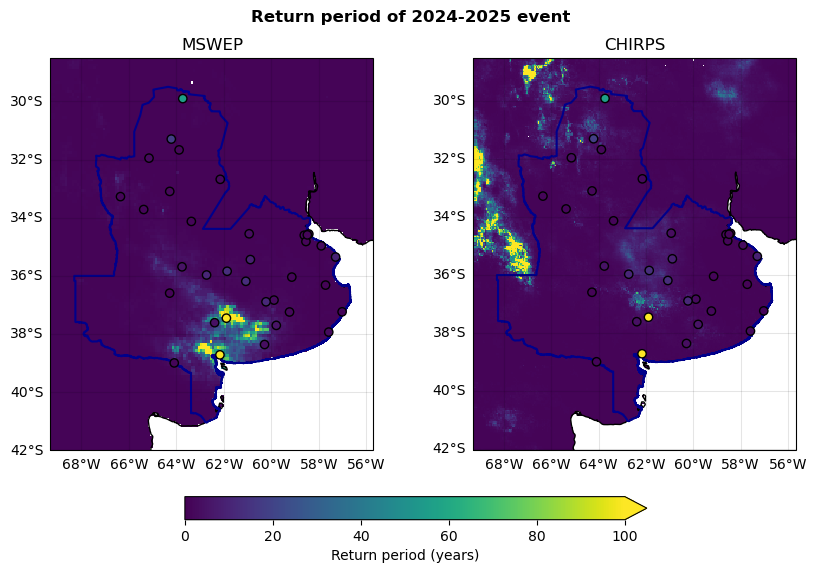

In [372]:
resnm = "return_period"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot_kwargs = {"dI_rel": {"cmap" : "RdBu", "vmin" : -100, "vmax" : 100},
               "return_period" : {"cmap" : "viridis", "vmin" : 0, "vmax" : 100}}
title = {"dI_rel" : "% change in rx7day", "return_period" : "Return period of 2024-2025 event"}
units = {"dI_rel" : "% change in rx7day", "return_period" : "Return period (years)"}

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (10,6))
plt.subplots_adjust(hspace = 0.05)

for i in range(2):
    ax = axs[i]
    da_nm = ["MSWEP", "CHIRPS"][i]
    da = eval(da_nm.lower())
    
    cbar = da[resnm].plot(ax = ax, **plot_kwargs[resnm],  add_colorbar = False)
    ax.scatter(stations.Lon, stations.Lat, c = stations[resnm], **plot_kwargs[resnm], edgecolor = "k", zorder = 99)

    ax.coastlines()
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
    sf.boundary.plot(ax = ax, color = "darkblue")

    ax.set_title(da_nm)

extend = "neither"
if da[resnm].max() > plot_kwargs[resnm]["vmax"]:
    if da[resnm].min() < plot_kwargs[resnm]["vmin"]:
        extend = "both"
    else:
        extend = "max"
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.1, label = units[resnm], extend = extend)
plt.suptitle(title[resnm], fontweight = "bold", y = 0.96)

# Nonlinear trends in stations

In [277]:
df = pd.read_csv("stations_rx7day.csv", index_col = "year")

def scale(ts): return (ts - ts.mean()) #/ ts.std() 

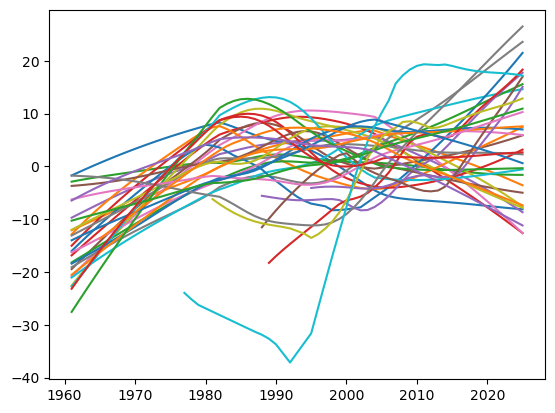

In [279]:
for cnm in df.columns:
    sm = lowess(df[cnm].values, df[cnm].index)
    plt.plot(sm[:,0], scale(sm[:,1]))

# Timing of hottest 31-day period

In [113]:
ts = xr.open_dataset("era5_tmax_ts_SES.nc").tmax

ts31 = ts.rolling(time = 91).mean()

dates = xr.concat([ts31.sel(time = slice(str(y)+"-07-01", str(y+1)+"-06-30")).idxmax() for y in range(1951,2025)], "time")
# dates = dates.assign_coords(time = dates.time)

In [114]:
dates.isel(time = -1)

<xarray.DataArray 'time' ()>
array('2025-03-10T00:00:00.000000000', dtype='datetime64[ns]')

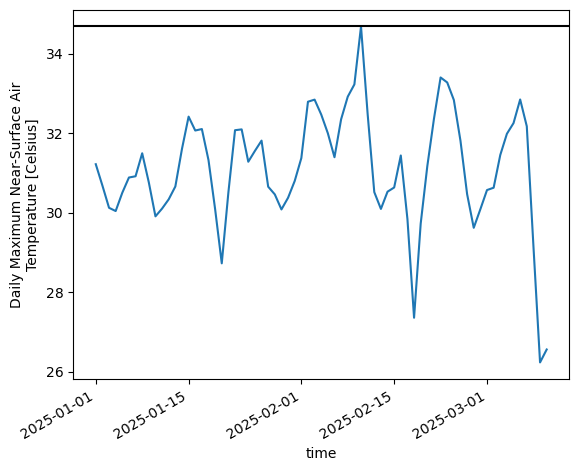

In [115]:
ts.sel(time = "2025").plot()
plt.axhline(ts.sel(time = "2025").max(), color = "k")

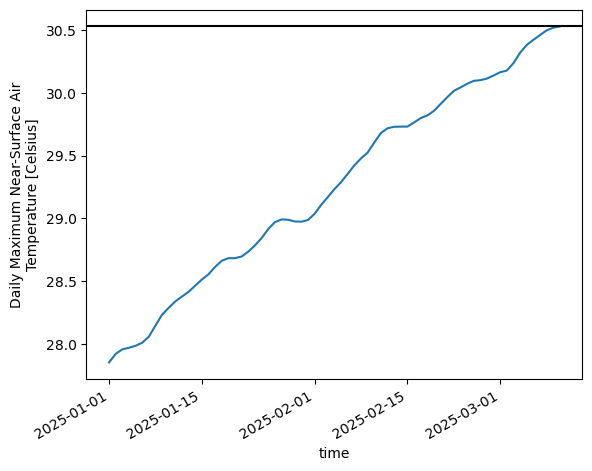

In [116]:
ts31.sel(time = "2025").plot()
plt.axhline(ts31.sel(time = "2025").max(), color = "k")

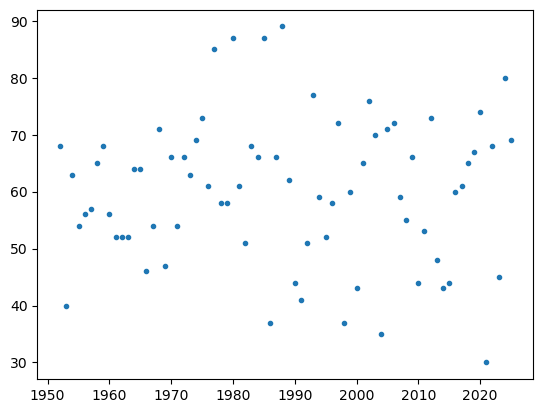

In [117]:
plt.plot(dates.dt.year, dates.dt.dayofyear, ls = "", marker = ".")

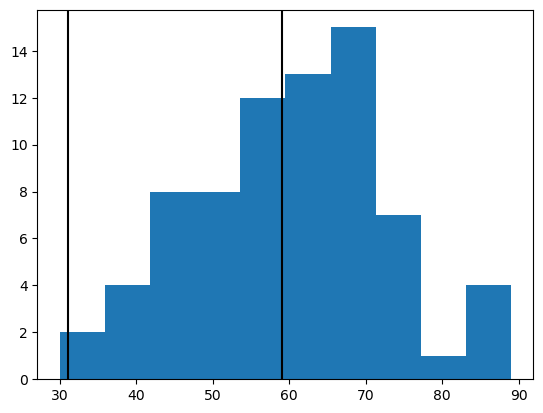

In [112]:
plt.hist(dates.dt.dayofyear)
[plt.axvline(x, color = "k") for x in [31,59]]

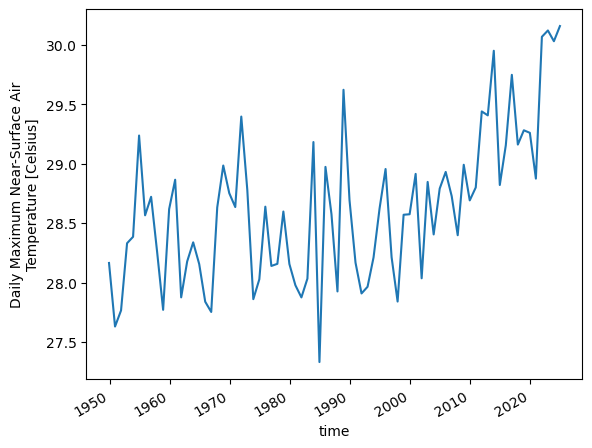

In [121]:
ts.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"].plot()